# Reinforcement Learning I: Value Iteration

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas

%matplotlib inline

The goal of this lab is to learn how to solve the reinforcement problem of finding an optimal policy for a Markov decision process with known transition probabilities and rewards.

We start by defining a Markov decision process (MDP) as a 5-tuple $(S,A,P,R,\gamma)$ with:

* $S$  a finite set of states,
* $A$ a finite set of actions,
* $P(s,a,s')$ as the probability that action $a$ in state $s$ at time $t$ will lead to state $s'$ at time $t + 1$,
* $R(s,a,s')$ is the immediate reward received after transitioning from state $s$ to state $s'$ due to action $a$,
* $\gamma \in [0,1]$ a discount factor.

We will work on a simple 4x4 grid world example. Each field in the grid is represented as a state (0-15).

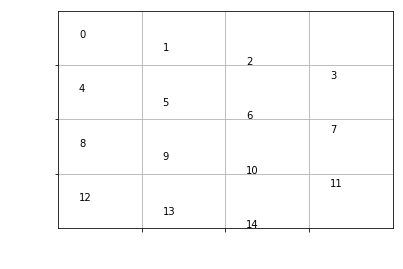

In [2]:
plt.plot()
plt.xlim(0, 4)
plt.ylim(4, 0)
plt.grid()
plt.xticks([1,2,3])
plt.yticks([1,2,3])
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
for i in range(16):
    y = i / 4
    x = i % 4 
    plt.annotate('{}'.format(i), xy=(x+0.25, y+0.5))

The agent can move from field to field by the actions 'up', 'down', 'right' and 'left'. State 0 and 15 are final states where no action is allowed. All actions that would cause the agent to move out of the grid should result in staying in the current field (eg. agent is in state 1 and takes action 'up' -> next state is 1).

We define the transition probabilities $P:S \times A \times S =1$ for all states and actions.<br>
We also give a reward $R: S \times A \times S =-1$ for all possible actions in all states.

In [3]:
states = np.arange(16)
actions = ['up', 'down', 'right', 'left']
transitions = {}
rewards = {}
for state in states:
    for action in actions:
        if state in [0, 15]:
            continue

        if ((action == 'up' and state in [1,2,3]) or
           (action == 'down' and state in [12,13,14]) or
           (action == 'right' and state in [3,7,11]) or
           (action == 'left' and state in [4,8,12])):
            next_state = state
        else:
            next_state = state + {'up': -4, 'down': 4, 'right': 1, 'left':-1}[action]
        transitions[(state, action, next_state)] = 1
        rewards[(state, action, next_state)] = -1
        
gamma = 0.9
gridwrold_mdp = (states, actions, transitions, rewards, gamma)

The state value function $V^{\pi}(s)$ is defined as the expected long-term reward of a policy $\pi$ starting from state $s$: $$V^{\pi}(s)=R^{\pi(s,a)}_{s}+\gamma \sum_{s'}[P^a_{s,s'} V^\pi(s')]$$

$V^\pi$ can either be solved by linear equations or by dynamic programming. The following algorithm (from "Reinforcement Learning - An Introduction", Richard S. Sutton and Andre G. Barto) shows the dynamic programming approach 

#### Policy Evaluation Algorithm:

Input $\pi$, the policy to be evaluated<br>
Initialize $V(s)=0$, for all $s \in S$<br>
Repeat<br>
&nbsp;&nbsp;&nbsp;&nbsp;$\Delta \leftarrow 0$<br>
&nbsp;&nbsp;&nbsp;&nbsp;For each $s \in S$:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$v \leftarrow V(s)$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$V(s) \leftarrow \sum_{a} \pi(s,a) \sum_{s'} P_{s,s'}^{a}[R_{s,s'}^{a} + \gamma V(s')]$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\Delta \leftarrow$ max $(\Delta, \vert v-V(s)\vert)$<br>
until $\Delta < \epsilon$<br>
Output $V$


The policy_evaluation method implements the algorithms.

In [6]:
def policy_evaluation(mdp, policy, epsilon=.001, max_iter=None):
    states, actions, transitions, rewards, gamma = mdp
    
    # look up table for next states 
    next_states = {}
    for state, action, next_state in transitions.keys():
        next_states[(state, action)] = next_state
    
    V = dict([(state, 0) for state in states])
    while True:
        delta = 0
        new_V = dict([(state, 0) for state in states])
        for state in states:
            for (state_, action), action_probability in policy.items():
                if state != state_:
                    continue
                next_state = next_states[(state, action)]
                
                reward = rewards[(state, action, next_state)]
                transition_probability = transitions[(state, action, next_state)]

                new_V[state] += action_probability * transition_probability * (reward + gamma * V[next_state])
            delta = max(delta, abs(V[state] - new_V[state]))
        V = new_V

        max_iter = max_iter - 1 if not max_iter is None else None
        if delta < epsilon or (not max_iter is None and max_iter <= 0):
            break
    return V

#### Question 1

The given implementation differs from the algorithm. What is the difference? Does it affect our grid world example?

#### Answer

The implementation assumes the MDP to be deterministic: each action results in exactly one state. Furthermore, we have an additional termination criterion which is the number of maximal iterations (if given).

Lets define a random walk policy where each action in each state has the same probability.

In [4]:
random_policy = {}
for state, action, _ in transitions.keys():
    random_policy[(state, action)] = 0.25

We can visualise the state value function for several iterations of the policy evaluation algorithm given the random policy.

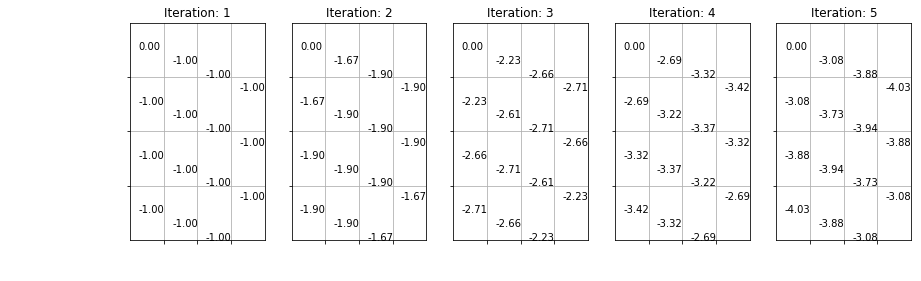

In [7]:
def plot_gridworld(V):
    plt.plot()
    plt.xlim(0, 4)
    plt.ylim(4, 0)
    plt.grid()
    plt.xticks([1,2,3])
    plt.yticks([1,2,3])
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    for state, v in V.items():
        y = state / 4
        x = state % 4 
        plt.annotate('{:.2f}'.format(v), xy=(x+0.25, y+0.5))

plt.figure(figsize=(14,4))
for n in range(1, 6):
    plt.subplot(1, 5, n)
    V = policy_evaluation(gridwrold_mdp,  random_policy, 0.001, n)
    plot_gridworld(V)
    plt.title('Iteration: ' + str(n))

#### Question 2

After which iteration does a greedy policy (always choosing the action leading to the next state with the highest expected reward) stop changing?

#### Answer

After iteration 3 the optimal routes don't change anymore.

#### Exercise 1

Write a policy $\pi$ that causes $V^{\pi}(3)$ (the corner field up/right) to get the lowest expected reward.

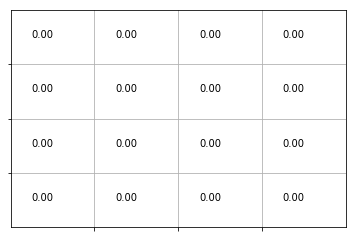

In [8]:
# Exercise

biased_policy = {}
for state, action, _ in transitions.keys():
    if state == 3:
        
    pass
        
V = policy_evaluation(gridwrold_mdp,  biased_policy, 0.001)
plot_gridworld(V)

Next we would like to find the optimal value function
$V^{*}=$max$_a[R^a + \gamma P^a V^{*}]$ and derive the best policy from it. A dynamic programming algorithm is given below.

#### Value iteration Algorithm:

Initialize $V(s)=0$, for all $s \in S$<br>
Repeat<br>
&nbsp;&nbsp;&nbsp;&nbsp;$\Delta \leftarrow 0$<br>
&nbsp;&nbsp;&nbsp;&nbsp;For each $s \in S$:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$v \leftarrow V(s)$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$V(s) \leftarrow$ max$_a \sum_{s'} P_{s,s'}^{a}[R_{s,s'}^{a} + \gamma V(s')]$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\Delta \leftarrow$ max $(\Delta, \vert v-V(s)\vert)$<br>
until $\Delta < \epsilon$

Output a deterministic policy, $\pi$, such that<br>
&nbsp;&nbsp;&nbsp;&nbsp;$\pi(s)=$arg max$_a \sum_{s'}P^a_{s,s'}[R_{s,s'}^{a} + \gamma V(s')]$<br>


In [9]:
def value_iteration(mdp, epsilon=.001, max_iter=None):
    states, actions, transitions, rewards, gamma = mdp
    
    V = dict([(state, 0) for state in states])
    while True:
        delta = 0
        new_V = dict([(state, 0) for state in states])
        for state in states:
            action_rewards = {}
            for (state_, action, next_state), transition_probability in transitions.items():
                if state != state_:
                    continue

                reward = rewards[(state, action, next_state)]
                action_reward = transition_probability * (reward + gamma * V[next_state])
                if action in action_rewards:
                    action_rewards[action] += action_reward
                else:
                    action_rewards[action] = action_reward

            new_V[state] = 0 if len(action_rewards.values()) == 0 else max(action_rewards.values())
            delta = max(delta, abs(V[state] - new_V[state]))
        V = new_V

        max_iter = max_iter - 1 if not max_iter is None else None
        if delta < epsilon or (not max_iter is None and max_iter <= 0):
            break
    return best_policy(mdp, V)

def best_policy(mdp, V):
    states, actions, transitions, rewards, gamma = mdp
    
    policy = {}
    for state in states:
        action_rewards = {}
        for (state_, action, next_state), transition_probability in transitions.items():
            if state != state_:
                continue

            reward = rewards[(state, action, next_state)]
            action_reward = transition_probability * (reward + gamma * V[next_state])
            if action in action_rewards:
                action_rewards[action] += action_reward
            else:
                action_rewards[action] = action_reward
        if len(action_rewards) > 0:
            policy[state] = action_rewards.keys()[np.argmax(action_rewards.values())]
    return policy

#### Question 3

Where is the optimal state-action value function $Q^{*}(s,a)$ (compare lecture slides) in the algorithm?

#### Answer

`best_policy` iterates over all states and actions of which $Q^{*}(s,a)$ is a part of.

We can now derive the optimal policy (optimal control actions for each state).

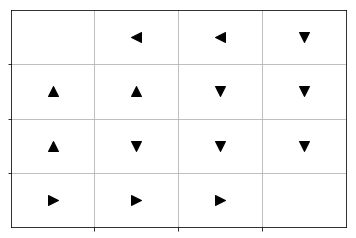

In [10]:
optimal_policy = value_iteration(gridwrold_mdp, 0.5)

def plot_gridworld_policy(policy):
    plt.plot()
    plt.xlim(0, 4)
    plt.ylim(4, 0)
    plt.grid()
    plt.xticks([1,2,3])
    plt.yticks([1,2,3])
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    
    for state, action in policy.items():
        y = state / 4 + 0.5
        x = state % 4  + 0.5
        plt.scatter(x, y, s=100, marker={'left': '<', 'right':'>','up':'^', 'down':'v'}[action], c='k')

plot_gridworld_policy(optimal_policy)

#### Question 4

Is there more than one optimal solution for our grid world?

#### Answer

Yes, one could e.g. also go to the left in state 3 or to the top in state 13.

#### Exercise 2

Create your own MDP (labyrinth with walls and bad fields, Tic-Tac-Toe game, ...) and learn an optimal policy. Visualise the solution. Be creative!

In [11]:
# Exercise


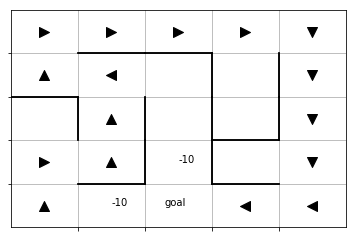

In [15]:
# Example
